RUN THIS FOR TESTING

In [1]:
import pandas as pd
import numpy as np
import struct
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from array import array
import os
from os.path  import join
import pickle
import matplotlib.pyplot as plt

Loading the images (RUN THIS FOR TESTING)

In [2]:

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test) 
    
    
input_path = "Data/"
training_images_filepath = join(input_path, 'train-images.idx3-ubyte')[:30000]
training_labels_filepath = join(input_path, 'train-labels.idx1-ubyte')[:30000]
test_images_filepath = join(input_path, 't10k-images.idx3-ubyte')[:6000]
test_labels_filepath = join(input_path, 't10k-labels.idx1-ubyte')[:6000]
    
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(X, y), (x_test, y_test) = mnist_dataloader.load_data()       

x_train, y_train = X[:30000], y[:30000]

x_remaining = X[30000:36000]
y_remaining = y[30000:36000]

x_val, x_test, y_val, y_test = train_test_split(x_remaining, y_remaining, test_size=0.5, random_state=42)

RUN THIS FOR TESTING

In [3]:
x_train = np.array(x_train)
y_train = np.array(y_train)

x_val = np.array(x_val)
y_val = np.array(y_val)

x_test = np.array(x_test)
y_test = np.array(y_test)

x_train = np.array(x_train).reshape(-1, 784).astype('float32') / 255.0
x_val = np.array(x_val).reshape(-1, 784).astype('float32') / 255.0
x_test = np.array(x_test).reshape(-1, 784).astype('float32') / 255.0

x_train.shape


(30000, 784)

Custom Neural Network Class (RUN THIS FOR TESTING)

In [4]:
class NeuralNetwork:
    def __init__(self, N=6, layer_sizes=[784,256,128,64,32,10], lr=2e-2, activation='relu', 
                 weight_init='random', epochs=100, batch_size=1024):
            
        self.N = N
        self.layer_sizes = layer_sizes
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.weights = []
        self.biases = []
        self.activation_name = activation
        self.weight_init_name = weight_init
        self.logs = {
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'epochs': []
        }
        

        if activation == 'relu':
            self.activation = self.relu
            self.activation_derivative = self.delu_relu
        
        elif activation == 'sigmoid':
            self.activation = self.sigmoid
            self.activation_derivative = self.del_sigmoid
            
        elif activation == "tanh":
            self.activation = self.tanh
            self.activation_derivative = self.del_tanh
        
        elif activation == "leaky_relu":
            self.activation = self.leaky_relu
            self.activation_derivative = self.delu_leaky_relu
            
        for i in range(N-1):
            if weight_init == 'zero':
                self.weights.append(np.zeros((layer_sizes[i+1], layer_sizes[i])))
            elif weight_init == 'random':
                self.weights.append(np.random.random((layer_sizes[i+1], layer_sizes[i])) - 0.5)
            elif weight_init == 'normal':
                self.weights.append(np.random.normal(0, 1, (layer_sizes[i+1], layer_sizes[i])))
            
            self.biases.append(np.zeros((layer_sizes[i+1], 1)))
            
    def loss(self, y_true, y_pred):
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))
            
    def forward(self, X):
        self.activations = [X.T]
        self.z_values = []
        
        for i in range(self.N-2):  # Hidden layers
            z = np.dot(self.weights[i], self.activations[-1]) + self.biases[i]
            self.z_values.append(z)
            self.activations.append(self.activation(z))
        
        # Output layer (softmax)
        z = np.dot(self.weights[-1], self.activations[-1]) + self.biases[-1]
        self.z_values.append(z)
        exp_scores = np.exp(z - np.max(z, axis=0, keepdims=True))
        self.activations.append(exp_scores / np.sum(exp_scores, axis=0, keepdims=True))
        
        return self.activations[-1]
    
    def backward(self, X, y):
        m = X.shape[0]
        delta = self.activations[-1] - y.T
        
        dW = []
        db = []
        
        dW.append(np.dot(delta, self.activations[-2].T) / m)
        db.append(np.sum(delta, axis=1, keepdims=True) / m)
        
        # Hidden layers
        for i in range(len(self.weights)-2, -1, -1):
            delta = np.dot(self.weights[i+1].T, delta) * self.activation_derivative(self.z_values[i])
            dW.append(np.dot(delta, self.activations[i].T) / m)
            db.append(np.sum(delta, axis=1, keepdims=True) / m)
        
        return dW[::-1], db[::-1]
    
    def fit(self, X_train, y_train, X_val=None, y_val=None):
        n_samples = X_train.shape[0]
        y_train_one_hot = np.eye(self.layer_sizes[-1])[y_train]
        
        # If validation data is not provided, use 20% of training data
        if X_val is None or y_val is None:
            val_size = int(0.2 * n_samples)
            indices = np.random.permutation(n_samples)
            X_val = X_train[indices[:val_size]]
            y_val = y_train[indices[:val_size]]
            X_train = X_train[indices[val_size:]]
            y_train = y_train[indices[val_size:]]
            y_train_one_hot = y_train_one_hot[indices[val_size:]]
            n_samples = X_train.shape[0]
        
        y_val_one_hot = np.eye(self.layer_sizes[-1])[y_val]
        
        for epoch in range(1, self.epochs + 1):
            # Mini-batch gradient descent
            indices = np.random.permutation(n_samples)
            epoch_losses = []
            
            for i in range(0, n_samples, self.batch_size):
                batch_indices = indices[i:min(i + self.batch_size, n_samples)]
                X_batch = X_train[batch_indices]
                y_batch = y_train_one_hot[batch_indices]
                
                # Forward and backward passes
                output = self.forward(X_batch)
                epoch_losses.append(self.loss(y_batch, output.T))
                dW, db = self.backward(X_batch, y_batch)
                
                # Update weights and biases
                for j in range(len(self.weights)):
                    self.weights[j] -= self.lr * dW[j]
                    self.biases[j] -= self.lr * db[j]
            
            if epoch % 10 == 0:
                train_loss = np.mean(epoch_losses)
                train_acc = self.score(X_train, y_train)
                
                val_output = self.predict_proba(X_val)
                val_loss = self.loss(y_val_one_hot, val_output)
                val_acc = self.score(X_val, y_val)

                self.logs['train_loss'].append(train_loss)
                self.logs['train_acc'].append(train_acc)
                self.logs['val_loss'].append(val_loss)
                self.logs['val_acc'].append(val_acc)
                self.logs['epochs'].append(epoch)
                
                
                print(f"Epoch {epoch}")
                print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
                print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
                print("-" * 50)
        
        y_pred = self.predict(X_val)
        report = classification_report(y_val, y_pred)
        
        
        print("\nFinal Classification Report:")
        print(report)
        
        self.plot_learning_curves()
        self.save_model()        
    
    def predict_proba(self, X):
        return self.forward(X).T
    
    def predict(self, X):
        probas = self.predict_proba(X)
        return np.argmax(probas, axis=1)
    
    def score(self, X, y):
        predictions = self.predict(X)
        return np.mean(predictions == y)
        
        
        
    # -----activation functions-----  
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def delu_relu(self, x):
        return np.where(x > 0, 1, 0)


    def sigmoid(self, x):
        x = np.clip(x, -500, 500)
        return 1 / (1 + np.exp(-x))

    def del_sigmoid(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))
    
    
    def tanh(self, x):
        return np.tanh(x)

    def del_tanh(self, x):
        return 1 - np.tanh(x)**2
    
    
    def leaky_relu(self, x):
        return np.maximum(0.01 * x, x)
    
    def delu_leaky_relu(self, x):
        return np.where(x > 0, 1, 0.01)
    
    # -----activation functions-----
    
    
    
    def plot_learning_curves(self):
        epochs = self.logs['epochs']
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        
        
        # loss plot
        ax1.plot(epochs, self.logs['train_loss'], label='Training Loss')
        ax1.plot(epochs, self.logs['val_loss'], label='Validation Loss')
        ax1.set_title(f'Loss Curves\n{self.activation_name} activation, {self.weight_init_name} init')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # accuracy plot
        ax2.plot(epochs, self.logs['train_acc'], label='Training Accuracy')
        ax2.plot(epochs, self.logs['val_acc'], label='Validation Accuracy')
        ax2.set_title(f'Accuracy Curves\n{self.activation_name} activation, {self.weight_init_name} init')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    def save_model(self):
        output_dir = 'Outputs/Models'
        os.makedirs(output_dir, exist_ok=True)

        filename = f"{output_dir}/model_{self.activation_name}_{self.weight_init_name}.pkl"
        with open(filename, 'wb') as f:
            pickle.dump(self, f)
        
        print(f"Model saved as: {filename}")
        return filename

# Training 

In [42]:
zero_relu = NeuralNetwork(activation='relu', weight_init='zero')
zero_sigmoid = NeuralNetwork(activation='sigmoid', weight_init='zero')
zero_tanh = NeuralNetwork(activation='tanh', weight_init='zero')
zero_leaky = NeuralNetwork(activation='leaky_relu', weight_init='zero')

random_relu = NeuralNetwork(activation='relu', weight_init='random')
random_sigmoid = NeuralNetwork(activation='sigmoid', weight_init='random')
random_tanh = NeuralNetwork(activation='tanh', weight_init='random')
random_leaky = NeuralNetwork(activation='leaky_relu', weight_init='random')

normal_relu = NeuralNetwork(activation='relu', weight_init='normal')
normal_sigmoid = NeuralNetwork(activation='sigmoid', weight_init='normal')
normal_tanh = NeuralNetwork(activation='tanh', weight_init='normal')
normal_leaky = NeuralNetwork(activation='leaky_relu', weight_init='normal')

Epoch 10
Train Loss: 2.3014, Train Acc: 0.1141
Val Loss: 2.3010, Val Acc: 0.1173
--------------------------------------------------
Epoch 20
Train Loss: 2.3010, Train Acc: 0.1141
Val Loss: 2.3005, Val Acc: 0.1173
--------------------------------------------------
Epoch 30
Train Loss: 2.3009, Train Acc: 0.1141
Val Loss: 2.3003, Val Acc: 0.1173
--------------------------------------------------
Epoch 40
Train Loss: 2.3010, Train Acc: 0.1141
Val Loss: 2.3002, Val Acc: 0.1173
--------------------------------------------------
Epoch 50
Train Loss: 2.3010, Train Acc: 0.1141
Val Loss: 2.3002, Val Acc: 0.1173
--------------------------------------------------
Epoch 60
Train Loss: 2.3010, Train Acc: 0.1141
Val Loss: 2.3002, Val Acc: 0.1173
--------------------------------------------------
Epoch 70
Train Loss: 2.3009, Train Acc: 0.1141
Val Loss: 2.3002, Val Acc: 0.1173
--------------------------------------------------
Epoch 80
Train Loss: 2.3009, Train Acc: 0.1141
Val Loss: 2.3001, Val Acc: 0.

c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


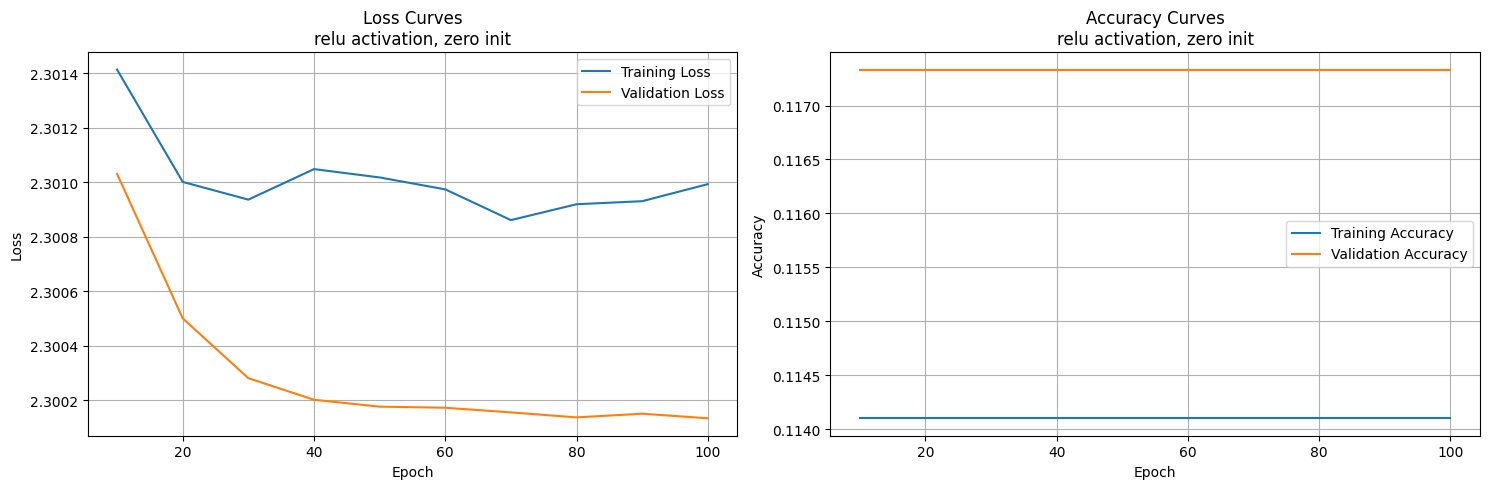

Model saved as: Outputs/Models/model_relu_zero.pkl
Accuracy:  0.11266666666666666


In [43]:
zero_relu.fit(x_train, y_train, x_val, y_val)
print("Accuracy: ", zero_relu.score(x_test, y_test))

Epoch 10
Train Loss: 2.3010, Train Acc: 0.1141
Val Loss: 2.3002, Val Acc: 0.1173
--------------------------------------------------
Epoch 20
Train Loss: 2.3009, Train Acc: 0.1141
Val Loss: 2.3002, Val Acc: 0.1173
--------------------------------------------------
Epoch 30
Train Loss: 2.3010, Train Acc: 0.1141
Val Loss: 2.3001, Val Acc: 0.1173
--------------------------------------------------
Epoch 40
Train Loss: 2.3009, Train Acc: 0.1141
Val Loss: 2.3001, Val Acc: 0.1173
--------------------------------------------------
Epoch 50
Train Loss: 2.3008, Train Acc: 0.1141
Val Loss: 2.3001, Val Acc: 0.1173
--------------------------------------------------
Epoch 60
Train Loss: 2.3010, Train Acc: 0.1141
Val Loss: 2.3001, Val Acc: 0.1173
--------------------------------------------------
Epoch 70
Train Loss: 2.3010, Train Acc: 0.1141
Val Loss: 2.3001, Val Acc: 0.1173
--------------------------------------------------
Epoch 80
Train Loss: 2.3010, Train Acc: 0.1141
Val Loss: 2.3001, Val Acc: 0.

c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


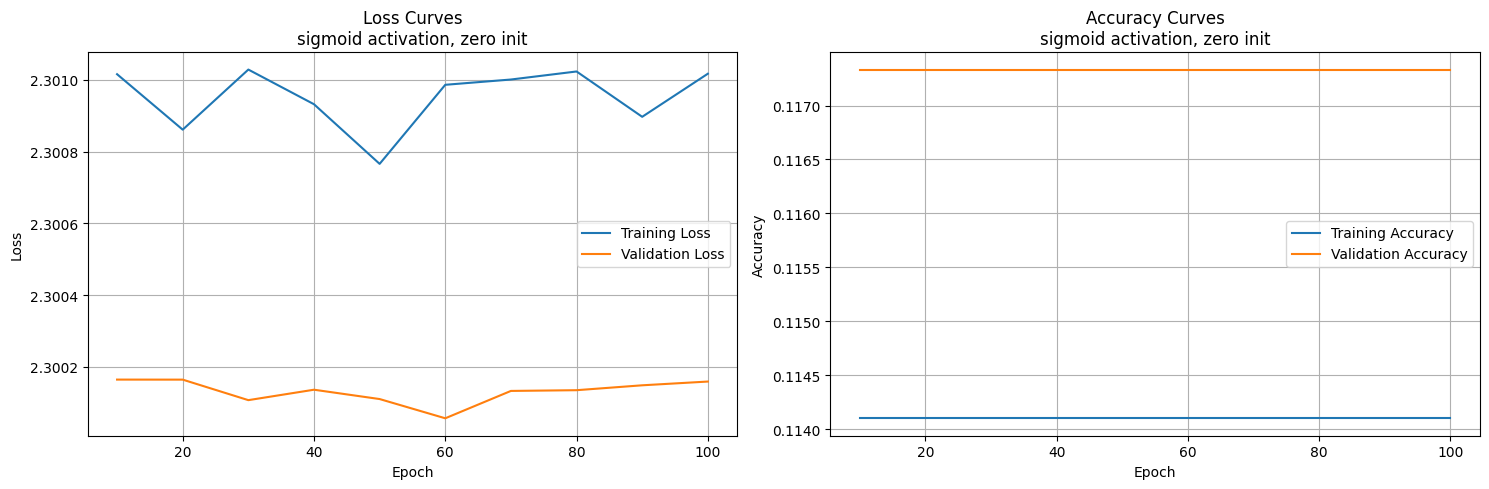

Model saved as: Outputs/Models/model_sigmoid_zero.pkl
Accuracy:  0.11266666666666666


In [44]:
zero_sigmoid.fit(x_train, y_train, x_val, y_val)
print("Accuracy: ", zero_sigmoid.score(x_test, y_test))

Epoch 10
Train Loss: 2.3014, Train Acc: 0.1141
Val Loss: 2.3011, Val Acc: 0.1173
--------------------------------------------------
Epoch 20
Train Loss: 2.3011, Train Acc: 0.1141
Val Loss: 2.3005, Val Acc: 0.1173
--------------------------------------------------
Epoch 30
Train Loss: 2.3009, Train Acc: 0.1141
Val Loss: 2.3003, Val Acc: 0.1173
--------------------------------------------------
Epoch 40
Train Loss: 2.3010, Train Acc: 0.1141
Val Loss: 2.3002, Val Acc: 0.1173
--------------------------------------------------
Epoch 50
Train Loss: 2.3008, Train Acc: 0.1141
Val Loss: 2.3002, Val Acc: 0.1173
--------------------------------------------------
Epoch 60
Train Loss: 2.3009, Train Acc: 0.1141
Val Loss: 2.3001, Val Acc: 0.1173
--------------------------------------------------
Epoch 70
Train Loss: 2.3010, Train Acc: 0.1141
Val Loss: 2.3001, Val Acc: 0.1173
--------------------------------------------------
Epoch 80
Train Loss: 2.3009, Train Acc: 0.1141
Val Loss: 2.3001, Val Acc: 0.

c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


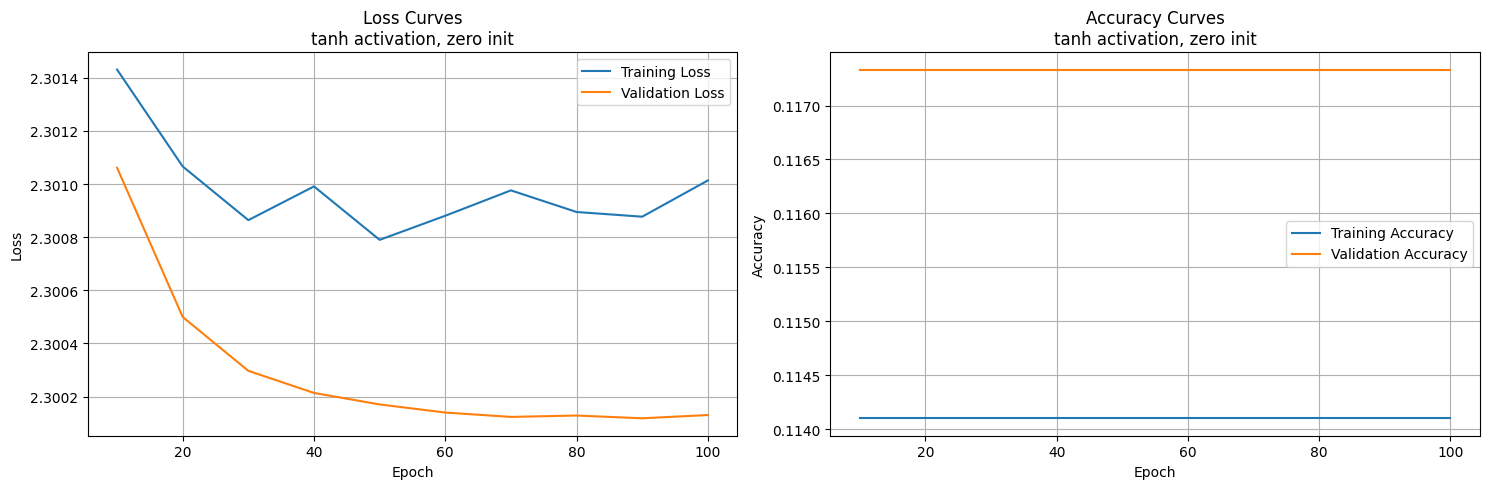

Model saved as: Outputs/Models/model_tanh_zero.pkl
Accuracy:  0.11266666666666666


In [45]:
zero_tanh.fit(x_train, y_train, x_val, y_val)
print("Accuracy: ", zero_tanh.score(x_test, y_test))

Epoch 10
Train Loss: 2.3014, Train Acc: 0.1141
Val Loss: 2.3010, Val Acc: 0.1173
--------------------------------------------------
Epoch 20
Train Loss: 2.3011, Train Acc: 0.1141
Val Loss: 2.3005, Val Acc: 0.1173
--------------------------------------------------
Epoch 30
Train Loss: 2.3010, Train Acc: 0.1141
Val Loss: 2.3003, Val Acc: 0.1173
--------------------------------------------------
Epoch 40
Train Loss: 2.3009, Train Acc: 0.1141
Val Loss: 2.3002, Val Acc: 0.1173
--------------------------------------------------
Epoch 50
Train Loss: 2.3007, Train Acc: 0.1141
Val Loss: 2.3002, Val Acc: 0.1173
--------------------------------------------------
Epoch 60
Train Loss: 2.3009, Train Acc: 0.1141
Val Loss: 2.3001, Val Acc: 0.1173
--------------------------------------------------
Epoch 70
Train Loss: 2.3008, Train Acc: 0.1141
Val Loss: 2.3001, Val Acc: 0.1173
--------------------------------------------------
Epoch 80
Train Loss: 2.3009, Train Acc: 0.1141
Val Loss: 2.3001, Val Acc: 0.

c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


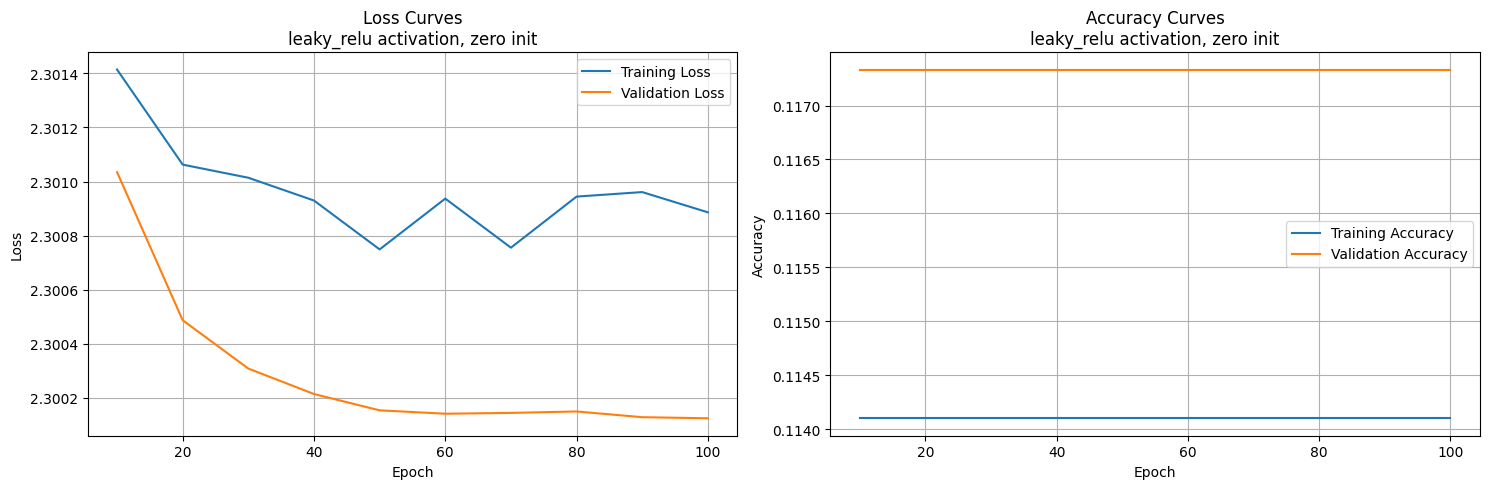

Model saved as: Outputs/Models/model_leaky_relu_zero.pkl
Accuracy:  0.11266666666666666


In [46]:
zero_leaky.fit(x_train, y_train, x_val, y_val)
print("Accuracy: ", zero_leaky.score(x_test, y_test))

Epoch 10
Train Loss: 1.4187, Train Acc: 0.5644
Val Loss: 1.4051, Val Acc: 0.5497
--------------------------------------------------
Epoch 20
Train Loss: 0.8476, Train Acc: 0.7341
Val Loss: 0.8863, Val Acc: 0.7230
--------------------------------------------------
Epoch 30
Train Loss: 0.5872, Train Acc: 0.8145
Val Loss: 0.6522, Val Acc: 0.8037
--------------------------------------------------
Epoch 40
Train Loss: 0.4789, Train Acc: 0.8580
Val Loss: 0.5313, Val Acc: 0.8443
--------------------------------------------------
Epoch 50
Train Loss: 0.4193, Train Acc: 0.8778
Val Loss: 0.4736, Val Acc: 0.8627
--------------------------------------------------
Epoch 60
Train Loss: 0.3761, Train Acc: 0.8900
Val Loss: 0.4502, Val Acc: 0.8663
--------------------------------------------------
Epoch 70
Train Loss: 0.3421, Train Acc: 0.9026
Val Loss: 0.4108, Val Acc: 0.8770
--------------------------------------------------
Epoch 80
Train Loss: 0.3153, Train Acc: 0.8981
Val Loss: 0.4305, Val Acc: 0.

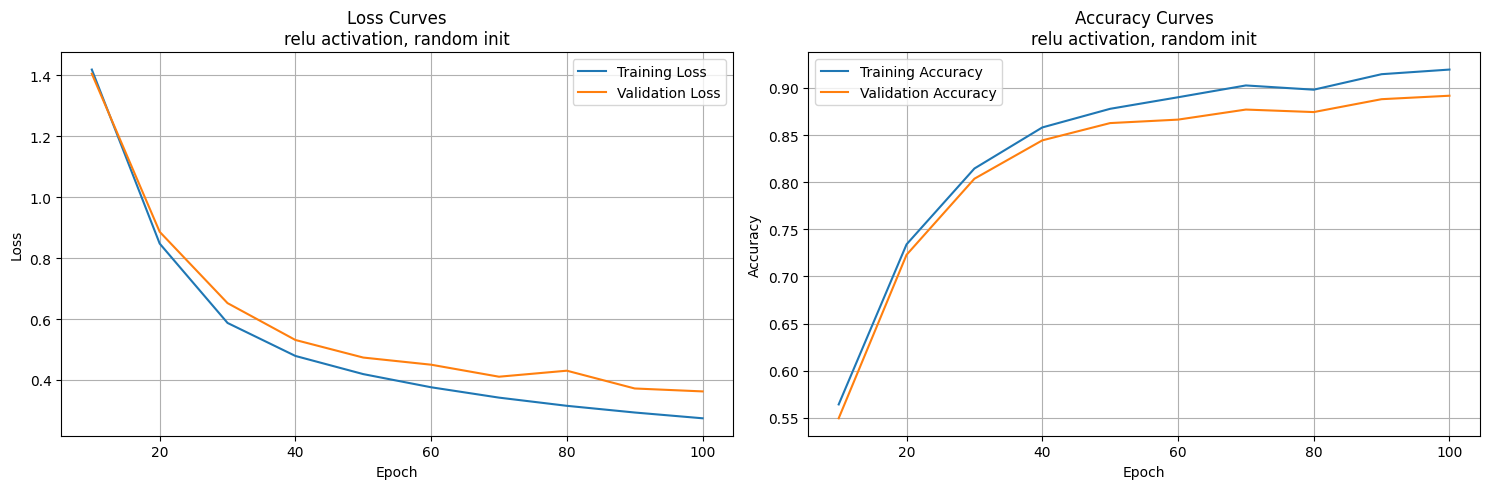

Model saved as: Outputs/Models/model_relu_random.pkl
Accuracy:  0.8926666666666667


In [47]:
random_relu.fit(x_train, y_train, x_val, y_val)
print("Accuracy: ", random_relu.score(x_test, y_test))

Epoch 10
Train Loss: 2.2818, Train Acc: 0.1502
Val Loss: 2.2831, Val Acc: 0.1437
--------------------------------------------------
Epoch 20
Train Loss: 2.2444, Train Acc: 0.2452
Val Loss: 2.2461, Val Acc: 0.2330
--------------------------------------------------
Epoch 30
Train Loss: 2.1889, Train Acc: 0.3324
Val Loss: 2.1917, Val Acc: 0.3167
--------------------------------------------------
Epoch 40
Train Loss: 2.1048, Train Acc: 0.4137
Val Loss: 2.1094, Val Acc: 0.3933
--------------------------------------------------
Epoch 50
Train Loss: 1.9807, Train Acc: 0.4691
Val Loss: 1.9877, Val Acc: 0.4447
--------------------------------------------------
Epoch 60
Train Loss: 1.8205, Train Acc: 0.5123
Val Loss: 1.8297, Val Acc: 0.4877
--------------------------------------------------
Epoch 70
Train Loss: 1.6519, Train Acc: 0.5508
Val Loss: 1.6649, Val Acc: 0.5370
--------------------------------------------------
Epoch 80
Train Loss: 1.5016, Train Acc: 0.5887
Val Loss: 1.5190, Val Acc: 0.

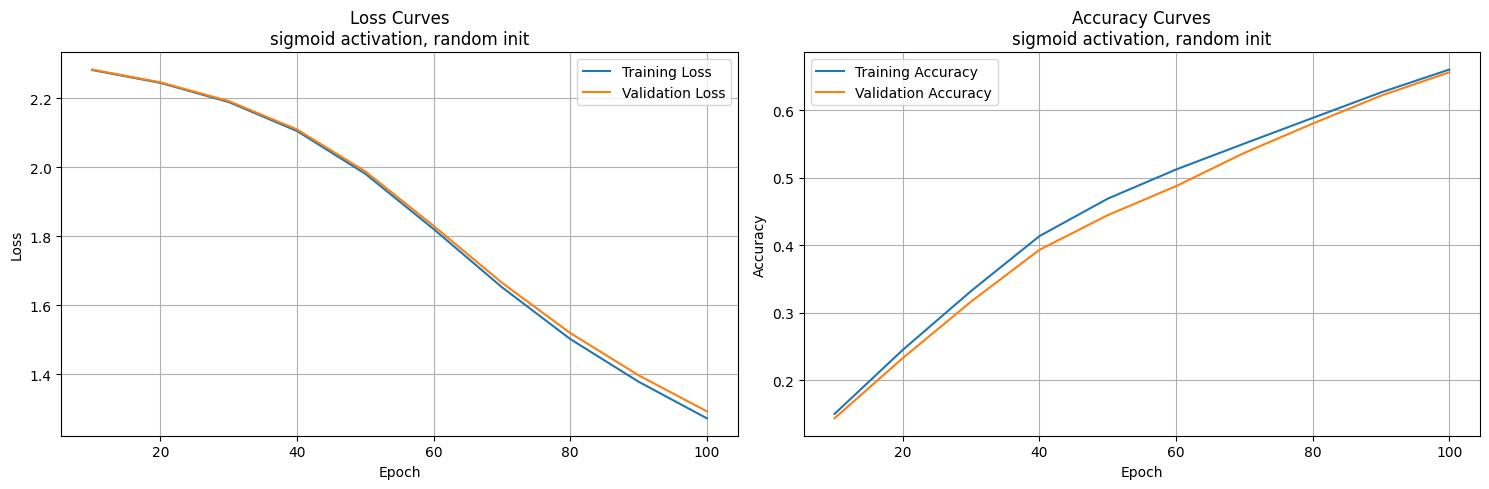

Model saved as: Outputs/Models/model_sigmoid_random.pkl
Accuracy:  0.638


In [48]:
random_sigmoid.fit(x_train, y_train, x_val, y_val)
print("Accuracy: ", random_sigmoid.score(x_test, y_test))

Epoch 10
Train Loss: 1.1005, Train Acc: 0.6593
Val Loss: 1.1247, Val Acc: 0.6310
--------------------------------------------------
Epoch 20
Train Loss: 0.7530, Train Acc: 0.7726
Val Loss: 0.8093, Val Acc: 0.7370
--------------------------------------------------
Epoch 30
Train Loss: 0.6027, Train Acc: 0.8210
Val Loss: 0.6733, Val Acc: 0.7843
--------------------------------------------------
Epoch 40
Train Loss: 0.5094, Train Acc: 0.8496
Val Loss: 0.5954, Val Acc: 0.8063
--------------------------------------------------
Epoch 50
Train Loss: 0.4503, Train Acc: 0.8685
Val Loss: 0.5446, Val Acc: 0.8213
--------------------------------------------------
Epoch 60
Train Loss: 0.4007, Train Acc: 0.8819
Val Loss: 0.5091, Val Acc: 0.8340
--------------------------------------------------
Epoch 70
Train Loss: 0.3660, Train Acc: 0.8921
Val Loss: 0.4823, Val Acc: 0.8470
--------------------------------------------------
Epoch 80
Train Loss: 0.3350, Train Acc: 0.9012
Val Loss: 0.4606, Val Acc: 0.

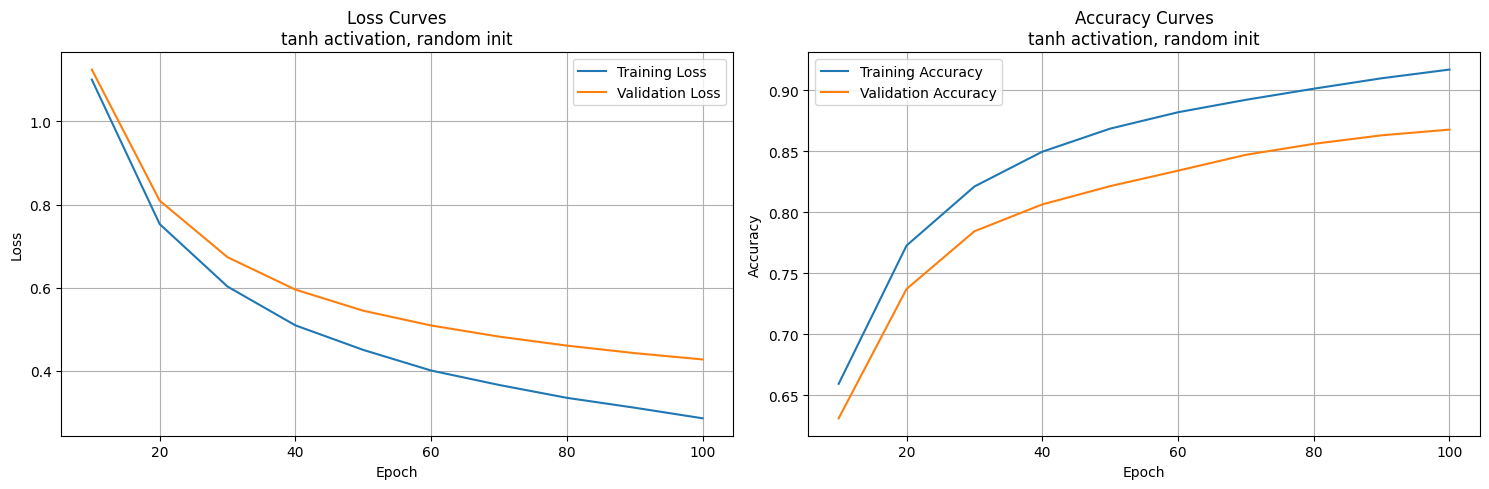

Model saved as: Outputs/Models/model_tanh_random.pkl
Accuracy:  0.863


In [49]:
random_tanh.fit(x_train, y_train, x_val, y_val)
print("Accuracy: ", random_tanh.score(x_test, y_test))

Epoch 10
Train Loss: 1.0687, Train Acc: 0.6707
Val Loss: 1.0977, Val Acc: 0.6500
--------------------------------------------------
Epoch 20
Train Loss: 0.6846, Train Acc: 0.7881
Val Loss: 0.7347, Val Acc: 0.7787
--------------------------------------------------
Epoch 30
Train Loss: 0.5314, Train Acc: 0.8389
Val Loss: 0.5841, Val Acc: 0.8177
--------------------------------------------------
Epoch 40
Train Loss: 0.4490, Train Acc: 0.8641
Val Loss: 0.5060, Val Acc: 0.8450
--------------------------------------------------
Epoch 50
Train Loss: 0.3965, Train Acc: 0.8726
Val Loss: 0.4752, Val Acc: 0.8477
--------------------------------------------------
Epoch 60
Train Loss: 0.3559, Train Acc: 0.8947
Val Loss: 0.4277, Val Acc: 0.8703
--------------------------------------------------
Epoch 70
Train Loss: 0.3237, Train Acc: 0.9025
Val Loss: 0.4053, Val Acc: 0.8807
--------------------------------------------------
Epoch 80
Train Loss: 0.3000, Train Acc: 0.9096
Val Loss: 0.3848, Val Acc: 0.

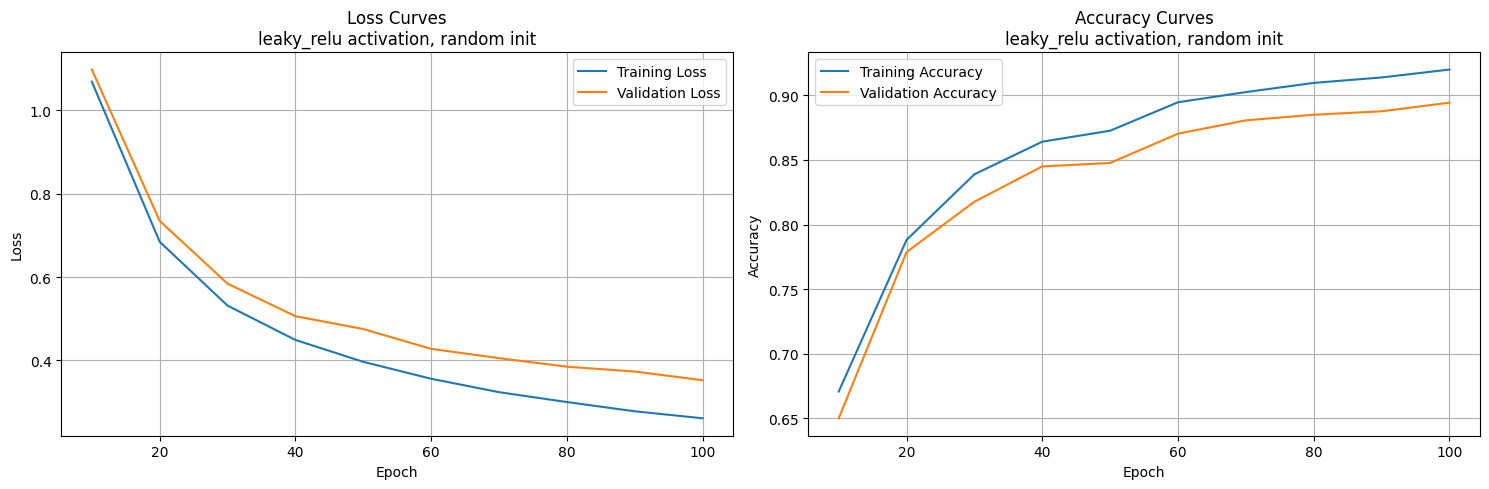

Model saved as: Outputs/Models/model_leaky_relu_random.pkl
Accuracy:  0.886


In [50]:
random_leaky.fit(x_train, y_train, x_val, y_val)
print("Accuracy: ", random_leaky.score(x_test, y_test))

Epoch 10
Train Loss: nan, Train Acc: 0.0987
Val Loss: nan, Val Acc: 0.1027
--------------------------------------------------
Epoch 20
Train Loss: nan, Train Acc: 0.0987
Val Loss: nan, Val Acc: 0.1027
--------------------------------------------------
Epoch 30
Train Loss: nan, Train Acc: 0.0987
Val Loss: nan, Val Acc: 0.1027
--------------------------------------------------
Epoch 40
Train Loss: nan, Train Acc: 0.0987
Val Loss: nan, Val Acc: 0.1027
--------------------------------------------------
Epoch 50
Train Loss: nan, Train Acc: 0.0987
Val Loss: nan, Val Acc: 0.1027
--------------------------------------------------
Epoch 60
Train Loss: nan, Train Acc: 0.0987
Val Loss: nan, Val Acc: 0.1027
--------------------------------------------------
Epoch 70
Train Loss: nan, Train Acc: 0.0987
Val Loss: nan, Val Acc: 0.1027
--------------------------------------------------
Epoch 80
Train Loss: nan, Train Acc: 0.0987
Val Loss: nan, Val Acc: 0.1027
-------------------------------------------

c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


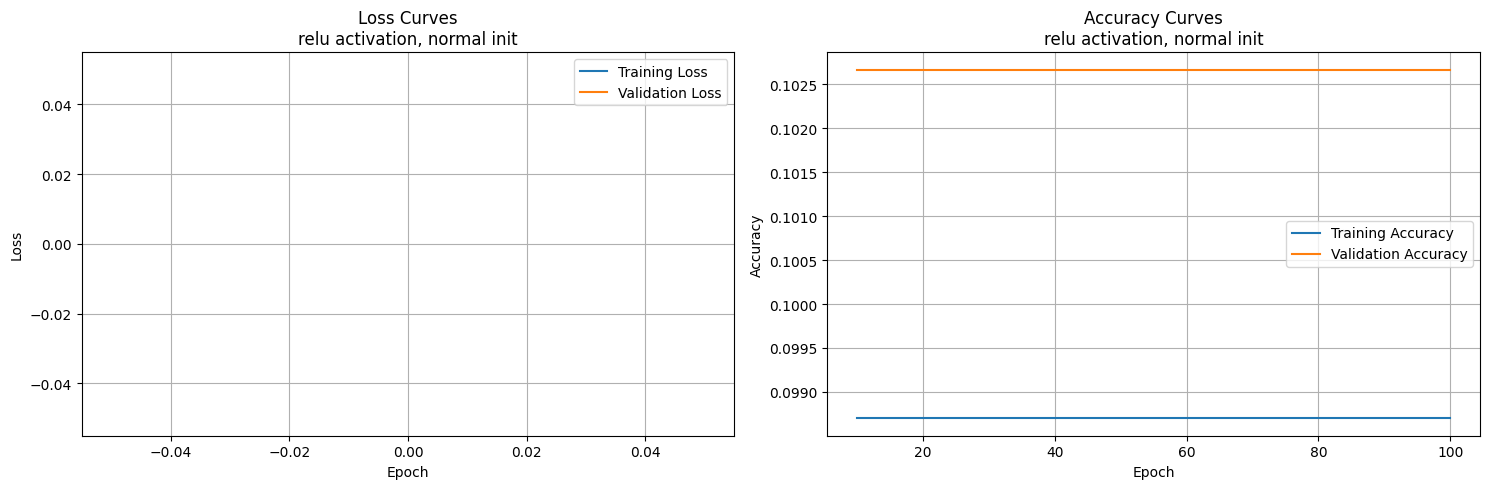

Model saved as: Outputs/Models/model_relu_normal.pkl
Accuracy:  0.08833333333333333


In [51]:
normal_relu.fit(x_train, y_train, x_val, y_val)
print("Accuracy: ", normal_relu.score(x_test, y_test))

Epoch 10
Train Loss: 2.2473, Train Acc: 0.2128
Val Loss: 2.2378, Val Acc: 0.2200
--------------------------------------------------
Epoch 20
Train Loss: 2.0803, Train Acc: 0.2850
Val Loss: 2.0835, Val Acc: 0.2867
--------------------------------------------------
Epoch 30
Train Loss: 1.9338, Train Acc: 0.3480
Val Loss: 1.9451, Val Acc: 0.3420
--------------------------------------------------
Epoch 40
Train Loss: 1.7913, Train Acc: 0.4031
Val Loss: 1.8125, Val Acc: 0.4013
--------------------------------------------------
Epoch 50
Train Loss: 1.6564, Train Acc: 0.4538
Val Loss: 1.6879, Val Acc: 0.4440
--------------------------------------------------
Epoch 60
Train Loss: 1.5360, Train Acc: 0.4974
Val Loss: 1.5742, Val Acc: 0.4767
--------------------------------------------------
Epoch 70
Train Loss: 1.4327, Train Acc: 0.5352
Val Loss: 1.4753, Val Acc: 0.5077
--------------------------------------------------
Epoch 80
Train Loss: 1.3470, Train Acc: 0.5673
Val Loss: 1.3928, Val Acc: 0.

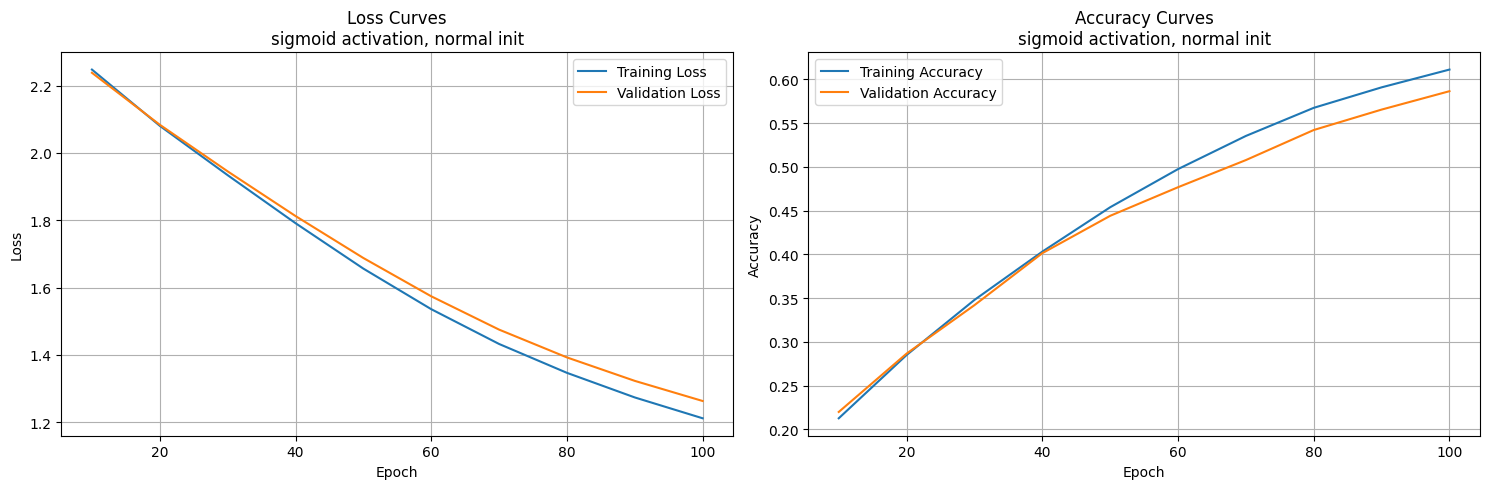

Model saved as: Outputs/Models/model_sigmoid_normal.pkl
Accuracy:  0.5886666666666667


In [52]:
normal_sigmoid.fit(x_train, y_train, x_val, y_val)
print("Accuracy: ", normal_sigmoid.score(x_test, y_test))

Epoch 10
Train Loss: 3.4876, Train Acc: 0.3177
Val Loss: 4.5070, Val Acc: 0.2217
--------------------------------------------------
Epoch 20
Train Loss: 2.3759, Train Acc: 0.4298
Val Loss: 3.7970, Val Acc: 0.2613
--------------------------------------------------
Epoch 30
Train Loss: 1.9180, Train Acc: 0.5014
Val Loss: 3.4591, Val Acc: 0.2837
--------------------------------------------------
Epoch 40
Train Loss: 1.6462, Train Acc: 0.5459
Val Loss: 3.2181, Val Acc: 0.3037
--------------------------------------------------
Epoch 50
Train Loss: 1.4783, Train Acc: 0.5848
Val Loss: 3.0514, Val Acc: 0.3210
--------------------------------------------------
Epoch 60
Train Loss: 1.3609, Train Acc: 0.6108
Val Loss: 2.9089, Val Acc: 0.3320
--------------------------------------------------
Epoch 70
Train Loss: 1.2639, Train Acc: 0.6309
Val Loss: 2.8127, Val Acc: 0.3373
--------------------------------------------------
Epoch 80
Train Loss: 1.1936, Train Acc: 0.6512
Val Loss: 2.7165, Val Acc: 0.

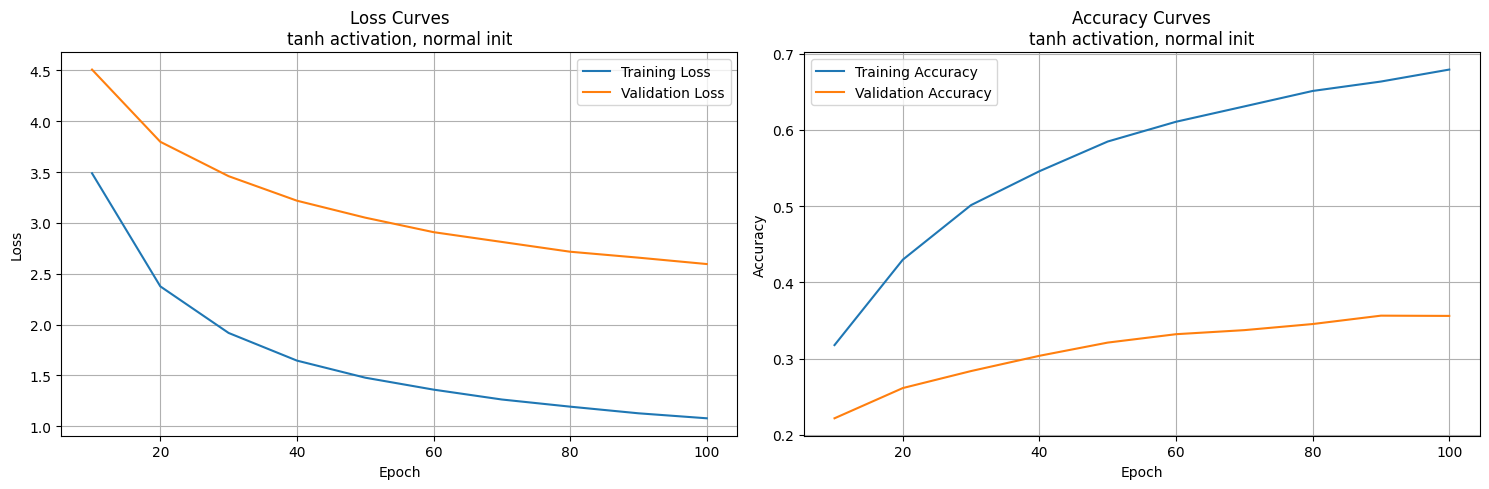

Model saved as: Outputs/Models/model_tanh_normal.pkl
Accuracy:  0.36766666666666664


In [53]:
normal_tanh.fit(x_train, y_train, x_val, y_val)
print("Accuracy: ", normal_tanh.score(x_test, y_test))

Epoch 10
Train Loss: nan, Train Acc: 0.0987
Val Loss: nan, Val Acc: 0.1027
--------------------------------------------------
Epoch 20
Train Loss: nan, Train Acc: 0.0987
Val Loss: nan, Val Acc: 0.1027
--------------------------------------------------
Epoch 30
Train Loss: nan, Train Acc: 0.0987
Val Loss: nan, Val Acc: 0.1027
--------------------------------------------------
Epoch 40
Train Loss: nan, Train Acc: 0.0987
Val Loss: nan, Val Acc: 0.1027
--------------------------------------------------
Epoch 50
Train Loss: nan, Train Acc: 0.0987
Val Loss: nan, Val Acc: 0.1027
--------------------------------------------------
Epoch 60
Train Loss: nan, Train Acc: 0.0987
Val Loss: nan, Val Acc: 0.1027
--------------------------------------------------
Epoch 70
Train Loss: nan, Train Acc: 0.0987
Val Loss: nan, Val Acc: 0.1027
--------------------------------------------------
Epoch 80
Train Loss: nan, Train Acc: 0.0987
Val Loss: nan, Val Acc: 0.1027
-------------------------------------------

c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


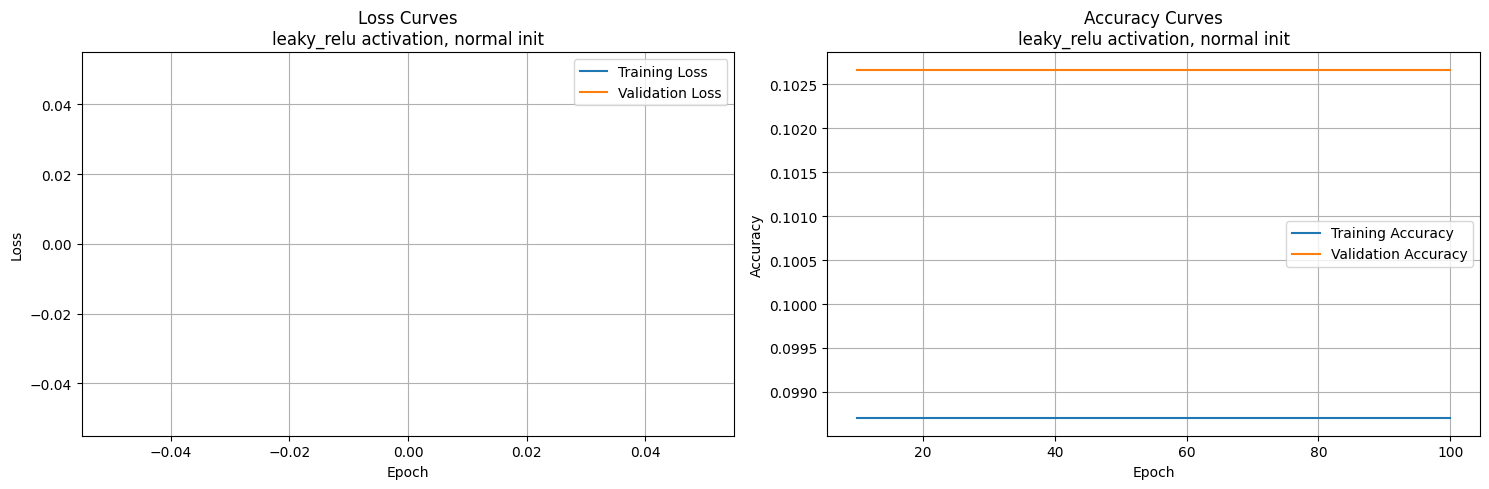

Model saved as: Outputs/Models/model_leaky_relu_normal.pkl
Accuracy:  0.08833333333333333


In [54]:
normal_leaky.fit(x_train, y_train, x_val, y_val)
print("Accuracy: ", normal_leaky.score(x_test, y_test))

# Testing the 12 models

In [5]:
PATH = "Outputs/Models/"

In [6]:
with open(PATH + "model_sigmoid_zero.pkl", 'rb') as f:
    nn = pickle.load(f)
    
print("Accuracy: ", nn.score(x_test, y_test))

Accuracy:  0.11266666666666666


In [7]:
with open(PATH + "model_sigmoid_random.pkl", 'rb') as f:
    nn = pickle.load(f)

print("Accuracy: ", nn.score(x_test, y_test))

Accuracy:  0.638


In [8]:
with open(PATH + "model_sigmoid_normal.pkl", 'rb') as f:
    nn = pickle.load(f)

print("Accuracy: ", nn.score(x_test, y_test))

Accuracy:  0.5886666666666667


In [59]:
with open(PATH + "model_tanh_zero.pkl", 'rb') as f:
    nn = pickle.load(f)

print("Accuracy: ", nn.score(x_test, y_test))

Accuracy:  0.11266666666666666


In [60]:
with open(PATH + "model_tanh_random.pkl", 'rb') as f:
    nn = pickle.load(f)

print("Accuracy: ", nn.score(x_test, y_test))

Accuracy:  0.863


In [61]:
with open(PATH + "model_tanh_normal.pkl", 'rb') as f:
    nn = pickle.load(f)

print("Accuracy: ", nn.score(x_test, y_test))

Accuracy:  0.36766666666666664


In [62]:
with open(PATH + "model_relu_zero.pkl", 'rb') as f:
    nn = pickle.load(f)

print("Accuracy: ", nn.score(x_test, y_test))

Accuracy:  0.11266666666666666


In [63]:
with open(PATH + "model_relu_random.pkl", 'rb') as f:
    nn = pickle.load(f)

print("Accuracy: ", nn.score(x_test, y_test))

Accuracy:  0.8926666666666667


In [64]:
with open(PATH + "model_relu_normal.pkl", 'rb') as f:
    nn = pickle.load(f)

print("Accuracy: ", nn.score(x_test, y_test))

Accuracy:  0.08833333333333333


In [65]:
with open(PATH + "model_leaky_relu_zero.pkl", 'rb') as f:
    nn = pickle.load(f)

print("Accuracy: ", nn.score(x_test, y_test))

Accuracy:  0.11266666666666666


In [66]:
with open(PATH + "model_leaky_relu_random.pkl", 'rb') as f:
    nn = pickle.load(f)

print("Accuracy: ", nn.score(x_test, y_test))

Accuracy:  0.886


In [67]:
with open(PATH + "model_leaky_relu_normal.pkl", 'rb') as f:
    nn = pickle.load(f)

print("Accuracy: ", nn.score(x_test, y_test))

Accuracy:  0.08833333333333333
